In [1]:
source('cascade_helper.R')

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0       ✔ purrr   0.3.1  
✔ tibble  2.0.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [2]:
annot.tbl <- '@@@@@@/private_data/ukbb/variant_filtering/variant_filter_table.tsv.gz'
res_dir_array <- '@@@@@@/users/mrivas/scratch/biomarker/paper/array/w_british'
res_dir_array_clumped <- '@@@@@@/projects/biomarkers/array_clumping'
outd<-file.path(getwd())


In [3]:
annot.arr <- read_annot_arr(annot.tbl)


In [4]:
colnames(annot.arr)

[1] "CHROM"             "POS"               "REF"              
 [4] "ALT"               "ID"                "Gene"             
 [7] "Consequence"       "HGVSp"             "LoF"              
[10] "LoF_filter"        "LoF_flags"         "LoF_info"         
[13] "consequence_field" "f_miss"            "f_miss_bileve"    
[16] "f_miss_wcsg"       "freq"              "hwe_p"            
[19] "maf"               "ld_indep"          "wcsg_only"        
[22] "bileve_only"       "filter"            "missingness"      
[25] "hwe"               "mcpi"              "gnomad_af"        
[28] "mgi"               "mgi_notes"         "all_filters"      
[31] "Gene_symbol"       "MAF"               "variant"          
[34] "Csq"

In [5]:
annot.arr %>% count(Csq)


Csq,n
non-coding,669033
protein-altering,87407
protein-truncating,27816


In [6]:
p_thr <- list(.01/100000, .01/100000, 5e-8)
names(p_thr) <- c('protein-truncating', 'protein-altering', 'non-coding')

In [7]:
traits <- read.csv(
    'traits.tsv', sep='\t',
    head=FALSE
)
colnames(traits) <- c('trait', 'file')


In [8]:
traits %>% head()

trait,file
Alanine_aminotransferase,ukb24983_v2.Alanine_aminotransferase_adjstatins.genotyped.glm.linear
Albumin,ukb24983_v2.Albumin_adjstatins.genotyped.glm.linear
Alkaline_phosphatase,ukb24983_v2.Alkaline_phosphatase.genotyped.glm.linear
Apolipoprotein_A,ukb24983_v2.Apolipoprotein_A_adjstatins.genotyped.glm.linear
Apolipoprotein_B,ukb24983_v2.Apolipoprotein_B_adjstatins.genotyped.glm.linear
Aspartate_aminotransferase,ukb24983_v2.Aspartate_aminotransferase_adjstatins.genotyped.glm.linear


In [9]:
df_Liver_Fat_percentage <- fread(
    cmd=(paste0(
        'cat ',
        '@@@@@@/users/mrivas/scratch/biomarker/paper/array/w_british/ukb24983_v2.INI22402.INI22402.glm.linear',
        '| cut -f3,6,9,10,12',
        '| sed -e "s/^#//g"'
    )),
    sep='\t', data.table=FALSE
) %>%
drop_na(BETA, SE, P) %>% 
mutate(BETA = as.numeric(BETA), SE = as.numeric(SE), P = as.numeric(P)) %>% 
mutate(trait = 'Liver_Fat_percentage') %>% left_join(annot.arr, by='ID') %>% 
select(
    trait, variant, CHROM, POS, ID, A1, BETA, SE, P, MAF, Csq, Consequence, HGVSp, Gene_symbol, Gene
) %>% 
mutate(
    chrom = as.numeric(CHROM), pos = as.numeric(POS),
    is_outside_of_MHC = (chrom == 6 & pos < 25477797) | ( chrom == 6 & 36448354 < pos) | chrom != 6
) %>% select(-chrom, -pos) 



In [10]:
dfs <- traits %>% select(trait) %>% pull() %>% lapply(read_arr_sumstats) 


In [11]:
df <- dfs %>% reduce(bind_rows) %>% mutate(
    trait = str_replace(trait, '.genotyped', ''),
    trait = str_replace(trait, '_lowcontrolonly', ''),
    trait = str_replace(trait, 'oestradiol_gt212', 'oestradiol'),
) %>% 
mutate(
    chrom = as.numeric(CHROM), pos = as.numeric(POS),
    is_outside_of_MHC = (chrom == 6 & pos < 25477797) | ( chrom == 6 & 36448354 < pos) | chrom != 6
) %>% select(-chrom, -pos) %>%
left_join(
    annot.arr %>% select(variant, ld_indep)
)


Joining, by = "variant"


In [12]:
df %>% dim()


[1] 214269     17

In [144]:
non_coding_hits_on_1KG <- fread(
    '@@@@@@/projects/biomarkers/paper/main/all.hits.tsv',
    sep='\t', data.table=F
) %>% 
mutate(
    chrom = as.numeric(CHROM), pos = as.numeric(POS),
    is_outside_of_MHC = (chrom == 6 & pos < 25477797) | ( chrom == 6 & 36448354 < pos) | chrom != 6
) %>% 
select(-chrom, -pos) %>%
left_join(
   annot.arr %>% select(ID, variant, Csq, Consequence, Gene_symbol), by='ID'
)

In [147]:
non_coding_hits_on_1KG %>% dim() %>% print()
non_coding_hits_on_1KG %>% head()

[1] 7762   23


TRAIT,TEST,id,best,CHROM,POS,ID,REF,ALT,ALT_FREQ,⋯,SE,T_STAT,P,NAME,CM,is_outside_of_MHC,variant,Csq,Consequence,Gene_symbol
Alanine_aminotransferase,ADD,1,1,1,2175553,rs142451335,T,C,0.927690,⋯,0.00484270,-6.94537,3.78179e-12,1_2175553_T_C,2.40124,TRUE,NA,NA,NA,NA
Alanine_aminotransferase,ADD,4,1,1,16494348,rs115630241,A,C,0.915187,⋯,0.00469424,6.20011,5.64924e-10,1_16494348_A_C,32.94750,TRUE,NA,NA,NA,NA
Alanine_aminotransferase,ADD,5,1,1,27260783,rs7545442,T,C,0.923445,⋯,0.00472225,-5.73704,9.64322e-09,1_27260783_T_C,50.17920,TRUE,NA,NA,NA,NA
Alanine_aminotransferase,ADD,7,1,1,50839740,rs2356864,G,A,0.522003,⋯,0.00250882,5.52225,3.34937e-08,1_50839740_G_A,76.27320,TRUE,NA,NA,NA,NA
Alanine_aminotransferase,ADD,8,1,1,59613905,rs12730750,A,G,0.645606,⋯,0.00264543,5.82595,5.68420e-09,1_59613905_A_G,87.11110,TRUE,NA,NA,NA,NA
Alanine_aminotransferase,ADD,9,1,1,66162631,rs6667616,A,C,0.810327,⋯,0.00324100,-6.67636,2.45353e-11,1_66162631_A_C,96.83940,TRUE,NA,NA,NA,NA


In [148]:
non_coding_hits_on_1KG %>% select(P) %>% max()

[1] 4.99919e-08

In [20]:
p_thr_df <- stack(p_thr) %>% rename(
    significant_thr = values,
    Csq = ind
)

p_thr_df


significant_thr,Csq
1e-07,protein-truncating
1e-07,protein-altering
5e-08,non-coding


In [21]:
df %>% left_join(p_thr_df) %>%
mutate(is_significant = as.numeric(P) < as.numeric(significant_thr)) %>%
filter(is_significant, is_outside_of_MHC) %>% 
select(variant, Csq, MAF, ld_indep) %>% unique() %>% 
mutate(is_rare = as.numeric(MAF) < 0.01) %>% select(-MAF) %>%
count(Csq)


Joining, by = "Csq"
Warning message:
“Column `Csq` joining character vector and factor, coercing into character vector”

Csq,n
non-coding,21366
protein-altering,2736
protein-truncating,123


In [22]:
df %>% left_join(p_thr_df) %>%
mutate(is_significant = as.numeric(P) < as.numeric(significant_thr)) %>%
filter(is_significant, is_outside_of_MHC) %>% 
select(variant, Csq, MAF, ld_indep) %>% unique() %>% 
mutate(is_rare = as.numeric(MAF) < 0.01) %>% select(-MAF) %>%
count(Csq, is_rare)


Joining, by = "Csq"
Warning message:
“Column `Csq` joining character vector and factor, coercing into character vector”

Csq,is_rare,n
non-coding,FALSE,21259
non-coding,TRUE,107
protein-altering,FALSE,2483
protein-altering,TRUE,253
protein-truncating,FALSE,75
protein-truncating,TRUE,48


In [23]:
df %>% left_join(p_thr_df) %>%
mutate(is_significant = as.numeric(P) < as.numeric(significant_thr)) %>%
filter(is_significant, is_outside_of_MHC) %>% 
select(variant, Csq, MAF, ld_indep) %>% unique() %>% 
mutate(is_rare = as.numeric(MAF) < 0.01) %>% select(-MAF) %>%
count(Csq, ld_indep, is_rare)


Joining, by = "Csq"
Warning message:
“Column `Csq` joining character vector and factor, coercing into character vector”

Csq,ld_indep,is_rare,n
non-coding,FALSE,FALSE,16476
non-coding,FALSE,TRUE,37
non-coding,TRUE,FALSE,4783
non-coding,TRUE,TRUE,70
protein-altering,FALSE,FALSE,2022
protein-altering,FALSE,TRUE,30
protein-altering,TRUE,FALSE,461
protein-altering,TRUE,TRUE,223
protein-truncating,FALSE,FALSE,64
protein-truncating,FALSE,TRUE,9


In [24]:
df_number_of_coding_hits_per_phenotype <- df %>% left_join(p_thr_df, by='Csq') %>%
mutate(is_significant = as.numeric(P) < as.numeric(significant_thr)) %>%
filter(is_significant, is_outside_of_MHC) %>% 
select(trait, variant, Csq) %>% 
filter(Csq != 'non-coding') %>%
count(trait, Csq) %>% 
spread(Csq, n, fill = 0) %>%
arrange(trait)

Warning message:
“Column `Csq` joining character vector and factor, coercing into character vector”

In [43]:
df_number_of_coding_hits_per_phenotype %>% 
fwrite(file.path(outd, 'number_of_coding_hits_per_phenotype.tsv'), sep='\t', row.names=FALSE)

In [45]:
file.path(outd, 'number_of_coding_hits_per_phenotype.tsv')

[1] "@@@@@@/projects/biomarkers/results/cascade/number_of_coding_hits_per_phenotype.tsv"

In [28]:
df %>% left_join(p_thr_df, by='Csq') %>%
mutate(is_significant = as.numeric(P) < as.numeric(significant_thr)) %>%
filter(is_significant, is_outside_of_MHC) %>% 
filter(Csq == 'protein-truncating') %>%
select(ID) %>% unique() %>% dim()

Warning message:
“Column `Csq` joining character vector and factor, coercing into character vector”

ID
rs140704858
rs145155876
Affx-89008673
rs192694811
rs202676
rs2289524


In [24]:
df %>% 
filter(
    is_outside_of_MHC,
    Csq == 'protein-truncating',
    as.numeric(P) < 1e-7,
    as.numeric(MAF) >=  0.01
) %>% select(variant) %>% unique() %>%
left_join(
    annot.arr
) %>% select(variant, ID, Gene_symbol, MAF, Csq, Consequence) %>% head(20)


Joining, by = "variant"


variant,ID,Gene_symbol,MAF,Csq,Consequence
11:49227620:A:G,rs202676,FOLH1,0.23948275,protein-truncating,stop_lost
15:78390414:T:C,rs2289524,SH2D7,0.43986913,protein-truncating,start_lost
1:21924912:A:G,rs61775974,RAP1GAP,0.04191965,protein-truncating,stop_lost
1:247615261:GA:G,rs35305980,OR2B11,0.45795543,protein-truncating,frameshift_variant
6:24806594:C:T,rs9358799,RIPOR2,0.45741988,protein-truncating,splice_donor_variant
7:106826381:C:CT,rs201145168,HBP1,0.22736178,protein-truncating,frameshift_variant
8:11296049:T:A,rs3021518,FAM167A-AS1,0.21541206,protein-truncating,stop_lost
8:19819724:C:G,rs328,LPL,0.10163491,protein-truncating,stop_gained
9:98638288:A:G,rs690528,ERCC6L2,0.31533774,protein-truncating,start_lost
9:136268037:ACGCTGGGC:A,Affx-52371914,STKLD1,0.42715362,protein-truncating,frameshift_variant


In [25]:
colnames(df)

[1] "trait"             "variant"           "CHROM"            
 [4] "POS"               "ID"                "A1"               
 [7] "BETA"              "SE"                "P"                
[10] "MAF"               "Csq"               "Consequence"      
[13] "HGVSp"             "Gene_symbol"       "Gene"             
[16] "is_outside_of_MHC" "ld_indep"

In [25]:
# df_non_coding <- df %>% filter(
#     Csq == 'non-coding',
#     P <= p_thr[['non-coding']]
# ) %>% outlier_detection()

df_protein_altering <- df %>% filter(
    Csq == 'protein-altering',
    P <= p_thr[['protein-altering']]    
) %>% outlier_detection()

df_protein_truncating <- df %>% filter(
    Csq == 'protein-truncating',
    P <= p_thr[['protein-truncating']]     
) %>% outlier_detection()



In [26]:
# df_non_coding %>% dim() %>% print()
df_protein_altering   %>% dim() %>% print()
df_protein_truncating %>% dim() %>% print()


[1] 8426   18
[1] 381  18


In [27]:
# df_non_coding %>% dim() %>% print()
df_protein_altering   %>% filter(is_outside_of_MHC) %>% dim() %>% print()
df_protein_truncating %>% filter(is_outside_of_MHC) %>% dim() %>% print()


[1] 6518   18
[1] 263  18


In [29]:
df %>% head()

trait,variant,CHROM,POS,ID,A1,BETA,SE,P,MAF,Csq,Consequence,HGVSp,Gene_symbol,Gene,is_outside_of_MHC,ld_indep
Alanine_aminotransferase,1:918270:C:T,1,918270,rs6659460,T,-0.0166554,0.00343255,1.22163e-06,0.15897150,non-coding,upstream_gene_variant,,PERM1,ENSG00000187642,TRUE,FALSE
Alanine_aminotransferase,1:2091762:C:T,1,2091762,rs75515273,T,0.0345253,0.00868704,7.05900e-05,0.02106885,non-coding,intron_variant,,PRKCZ,ENSG00000067606,TRUE,TRUE
Alanine_aminotransferase,1:2139916:C:T,1,2139916,rs115111747,T,0.0346381,0.00856507,5.25356e-05,0.02168240,non-coding,intron_variant,,FAAP20,ENSG00000162585,TRUE,FALSE
Alanine_aminotransferase,1:2165918:G:C,1,2165918,rs12061341,C,0.0312296,0.00468214,2.56343e-11,0.07729211,non-coding,intron_variant,,SKI,ENSG00000157933,TRUE,FALSE
Alanine_aminotransferase,1:2169079:C:T,1,2169079,rs10910032,T,0.0193333,0.00384670,5.01192e-07,0.11963136,non-coding,intron_variant,,SKI,ENSG00000157933,TRUE,FALSE
Alanine_aminotransferase,1:2173504:T:C,1,2173504,rs263526,C,-0.0104037,0.00257156,5.21806e-05,0.38452375,non-coding,intron_variant,,SKI,ENSG00000157933,TRUE,TRUE


In [28]:
# df_non_coding %>% fwrite(file.path(outd, 'sumstats.non_coding.tsv'), sep='\t', row.names=FALSE)

df_protein_altering   %>% select(-CHROM, -POS) %>% 
mutate(outlier = if_else(abs(BETA) >= .1, TRUE, FALSE),) %>% 
fwrite(file.path(outd, 'sumstats.protein_altering.tsv'), sep='\t', row.names=FALSE)

df_protein_truncating %>% select(-CHROM, -POS) %>% 
mutate(outlier = if_else(abs(BETA) >= .1, TRUE, FALSE),) %>% 
fwrite(file.path(outd, 'sumstats.protein_truncating.tsv'), sep='\t', row.names=FALSE)


In [29]:
df_Liver_Fat_percentage %>% 
filter(P <= 1e-2) %>% outlier_detection() %>% 
mutate(outlier = if_else(abs(BETA) >= .1, TRUE, FALSE),) %>% 
filter(is_outside_of_MHC)%>% select(-CHROM, -POS) %>% 
fwrite(file.path(outd, 'sumstats.Liver_Fat_percentage_1e-2.tsv'), sep='\t', row.names=FALSE)

In [30]:
df_Liver_Fat_percentage %>% outlier_detection() %>% 
mutate(outlier = if_else(abs(BETA) >= .1, TRUE, FALSE),) %>% 
filter(is_outside_of_MHC)%>% select(-CHROM, -POS) %>% 
fwrite(file.path(outd, 'sumstats.Liver_Fat_percentage.tsv'), sep='\t', row.names=FALSE)


In [31]:
getwd()

[1] "@@@@@@/projects/biomarkers/results/cascade"

In [39]:
df %>% select(trait) %>% unique() %>% full_join(
    df_protein_truncating %>% select(trait) %>% unique() %>% mutate(ptv_trait = trait) 
)


Joining, by = "trait"


trait,ptv_trait
Alanine_aminotransferase,Alanine_aminotransferase
Albumin,Albumin
Alkaline_phosphatase,Alkaline_phosphatase
Apolipoprotein_A,Apolipoprotein_A
Apolipoprotein_B,Apolipoprotein_B
Aspartate_aminotransferase,Aspartate_aminotransferase
Calcium,Calcium
Cholesterol,Cholesterol
C_reactive_protein,C_reactive_protein
Creatinine,Creatinine


In [40]:
df_protein_truncating %>% select(trait) %>% unique() %>% dim()


[1] 36  1

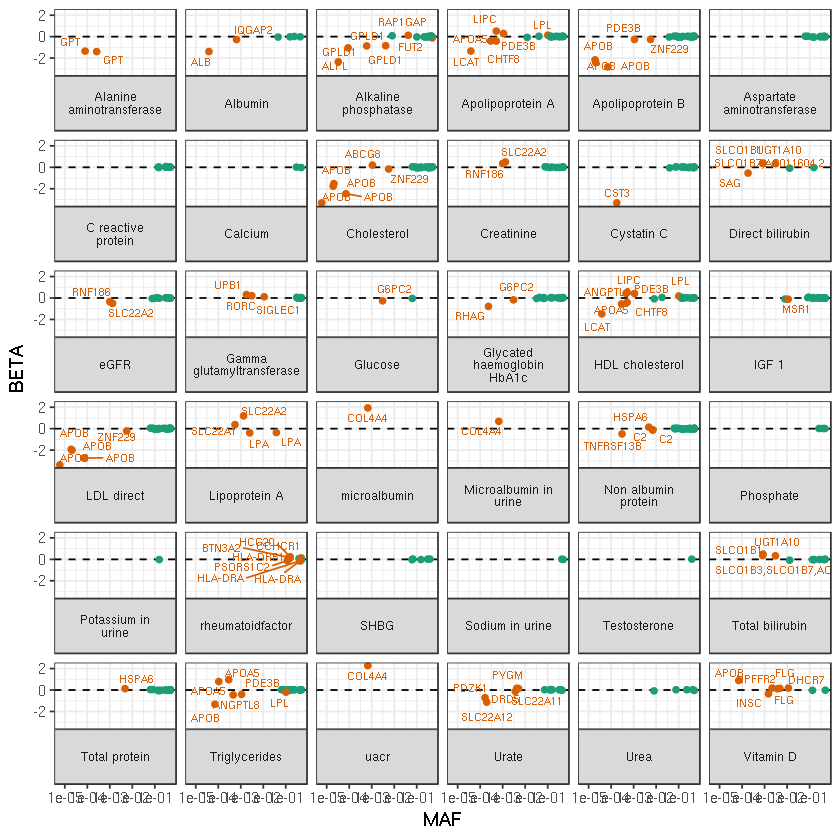

In [43]:
df_protein_truncating %>% mutate(
    outlier = if_else(abs(BETA) >= .1, TRUE, FALSE),
    trait = str_replace_all(trait, '_', ' '),   
    ggrepel = if_else(outlier == TRUE, Gene_symbol, "")
) %>%
ggplot(
    aes(x=MAF, y=BETA, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point() + theme_bw() + 
theme(
    strip.text = element_text(size=7),
    legend.position="none"
)+
scale_color_brewer(palette="Dark2") + 
scale_x_continuous(trans="log10") + 
facet_wrap(~trait, ncol = 6, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=2) 



In [42]:
traits_first_half <- traits %>% mutate(
    trait = str_replace(trait, '.genotyped', ''),
    trait = str_replace(trait, '_lowcontrolonly', ''),
    trait = str_replace(trait, 'oestradiol_gt212', 'oestradiol'),
) %>% select(trait) %>% arrange(trait) %>% top_n(19) %>% pull() %>% as.vector()


Selecting by trait


In [43]:
traits_first_half

[1] "LDL_direct"            "Lipoprotein_A"         "microalbumin"         
 [4] "Microalbumin_in_urine" "Non_albumin_protein"   "oestradiol"           
 [7] "Phosphate"             "Potassium_in_urine"    "rheumatoidfactor"     
[10] "SHBG"                  "Sodium_in_urine"       "Testosterone"         
[13] "Total_bilirubin"       "Total_protein"         "Triglycerides"        
[16] "uacr"                  "Urate"                 "Urea"                 
[19] "Vitamin_D"

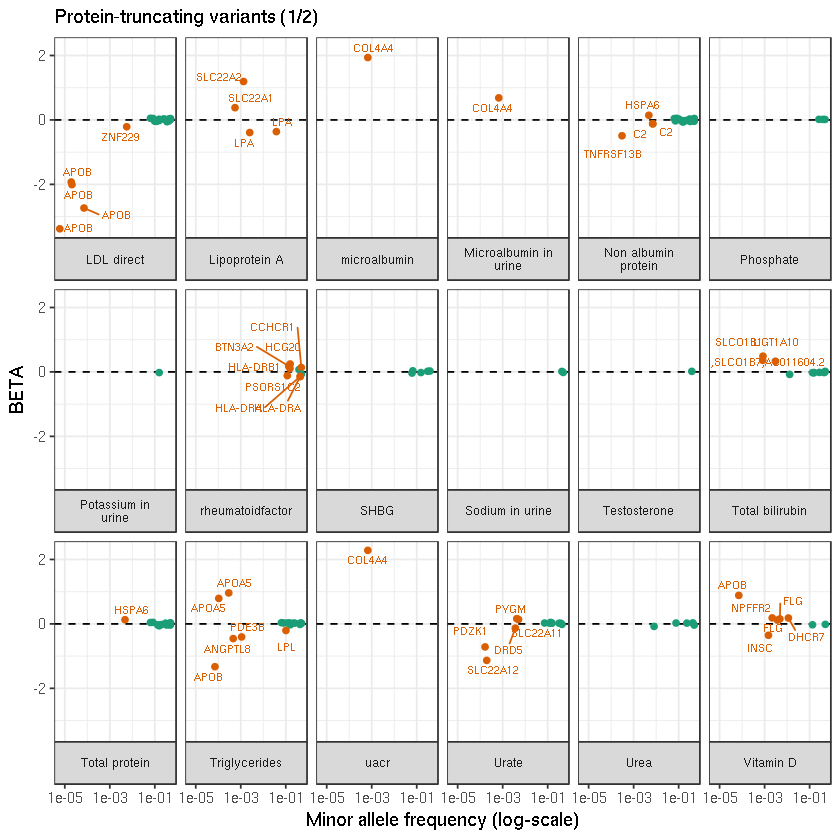

In [59]:
df_protein_truncating %>% 
filter(
    trait %in% traits_first_half
) %>%
mutate(
    outlier = if_else(abs(BETA) >= .1, TRUE, FALSE),
    trait = str_replace_all(trait, '_', ' '),   
    ggrepel = if_else(abs(BETA) >= .1, Gene_symbol, "")
) %>%
ggplot(
    aes(x=MAF, y=BETA, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point() + theme_bw() + 
labs(
    title = 'Protein-truncating variants (1/2)',
    x = 'Minor allele frequency (log-scale)'
) +
theme(
    strip.text = element_text(size=7),
    legend.position="none"
)+
scale_color_brewer(palette="Dark2") + 
scale_x_continuous(trans="log10", breaks=10 * 100**(-3:-1)) + 
facet_wrap(~trait, ncol = 6, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=2)


In [60]:
ggsave('cascade_ptv1.png')

Saving 6.67 x 6.67 in image


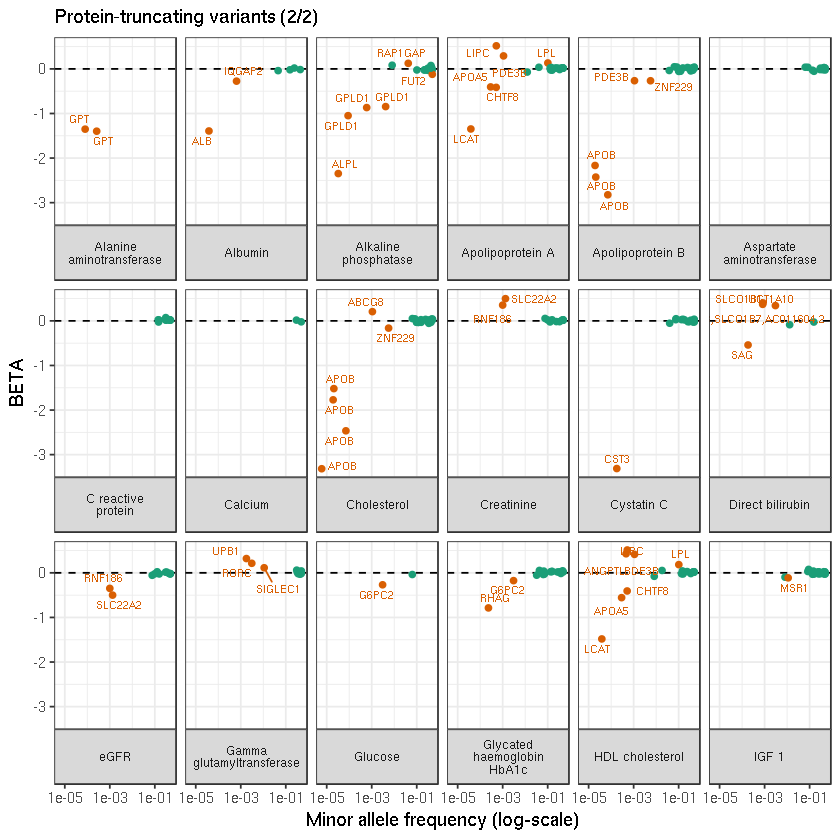

In [61]:
df_protein_truncating %>% 
filter(
    ! trait %in% traits_first_half
) %>%
mutate(
    outlier = if_else(abs(BETA) >= .1, TRUE, FALSE),
    trait = str_replace_all(trait, '_', ' '),   
    ggrepel = if_else(abs(BETA) >= .1, Gene_symbol, "")
) %>%
ggplot(
    aes(x=MAF, y=BETA, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point() + theme_bw() + 
labs(
    title = 'Protein-truncating variants (2/2)',
    x = 'Minor allele frequency (log-scale)'
) +
theme(
    strip.text = element_text(size=7),
    legend.position="none"    
)+
scale_color_brewer(palette="Dark2") + 
scale_x_continuous(trans="log10", breaks=10 * 100**(-3:-1)) + 
facet_wrap(~trait, ncol = 6, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=2)

In [62]:
ggsave('cascade_ptv2.png')

Saving 6.67 x 6.67 in image


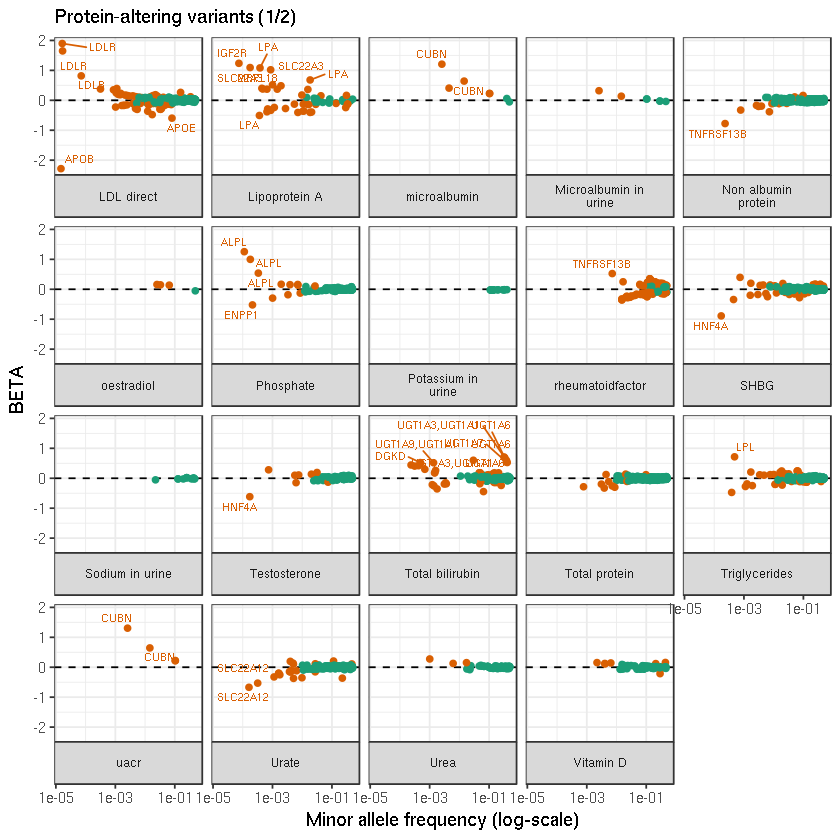

In [64]:
df_protein_altering %>% 
filter(
    trait %in% traits_first_half
) %>%
mutate(
    outlier = if_else(abs(BETA) >= .1, TRUE, FALSE),
    trait = str_replace_all(trait, '_', ' '),   
    ggrepel = if_else(abs(BETA) >= .5, Gene_symbol, "")
) %>%
ggplot(
    aes(x=MAF, y=BETA, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point() + theme_bw() + 
theme(
    strip.text = element_text(size=7),
    legend.position="none"
)+
labs(
    title = 'Protein-altering variants (1/2)',
    x = 'Minor allele frequency (log-scale)'
) +
scale_color_brewer(palette="Dark2") + 
scale_x_continuous(trans="log10", breaks=10 * 100**(-3:-1)) + 
facet_wrap(~trait, ncol = 5, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=2)

In [65]:
ggsave('cascade_protein_altering1.png')


Saving 6.67 x 6.67 in image


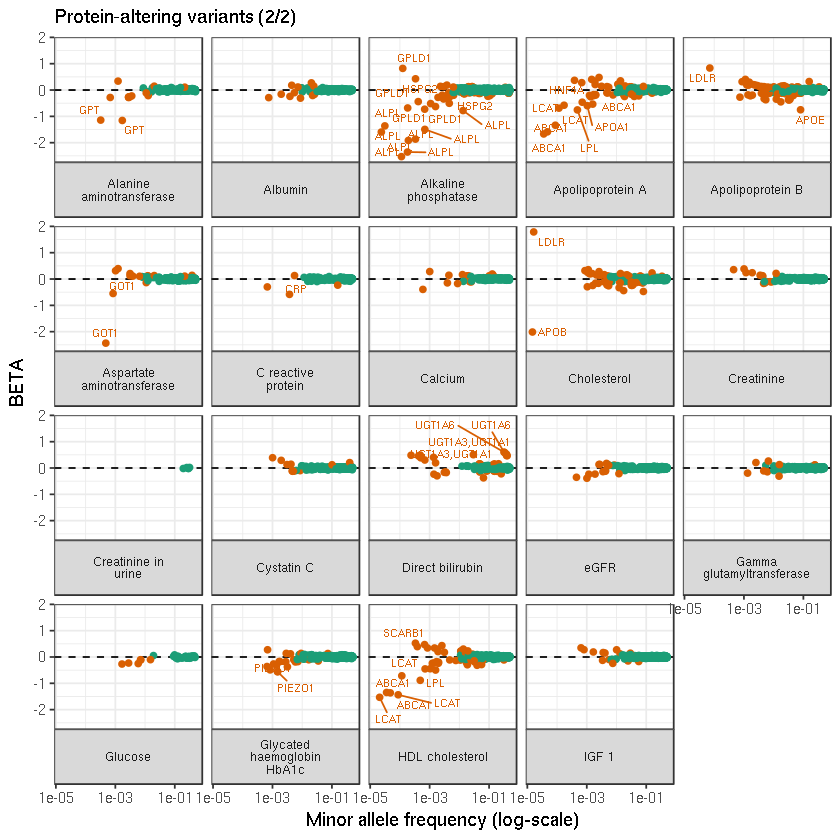

In [66]:
df_protein_altering %>% 
filter(
    ! trait %in% traits_first_half
) %>%
mutate(
    outlier = if_else(abs(BETA) >= .1, TRUE, FALSE),
    trait = str_replace_all(trait, '_', ' '),   
    ggrepel = if_else(abs(BETA) >= .5, Gene_symbol, "")
) %>%
ggplot(
    aes(x=MAF, y=BETA, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point() + theme_bw() + 
theme(
    strip.text = element_text(size=7),
    legend.position="none"    
)+
labs(
    title = 'Protein-altering variants (2/2)',
    x = 'Minor allele frequency (log-scale)'
) +
scale_color_brewer(palette="Dark2") + 
scale_x_continuous(trans="log10", breaks=10 * 100**(-3:-1)) + 
facet_wrap(~trait, ncol = 5, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=2)


In [67]:
ggsave('cascade_protein_altering2.png')


Saving 6.67 x 6.67 in image


In [33]:
read_plink_clumped <- function(file){
    fread(
        cmd=paste0(
            'cat ', file, ' | sed -e "s/^#//g"'
        ), 
        data.table=F
    ) %>% 
    mutate(P = as.numeric(P)) %>% 
    rename(
        index_SNP = SNP
    ) %>%
    mutate(
        SNP = str_replace_all(SP2, '[(]1[)]', ''),
        SNP = str_replace_all(SNP, 'NONE', ''),
        SNP = paste(index_SNP, SNP, sep=','),
        SNP = as.list(strsplit(SNP, ','))
    ) %>%
    select(SNP, index_SNP, P) %>% 
    unnest(SNP)    
}

In [34]:
get_non_coding_only_index_SNPs <- function(clump_df, annot.arr){
    exclude_list <- clump_df %>% rename(ID = SNP) %>% left_join(annot.arr %>% select(ID, Csq), by='ID') %>%
    filter(Csq != 'non-coding') %>% select(index_SNP) %>% unique() %>% pull()
    clump_df %>% 
    filter(
        ! index_SNP %in% exclude_list
    )%>% select(index_SNP, P) %>% unique()
}

In [35]:
read_arr_sumstats <- function(trait, traits_df = traits, p_thr_list = p_thr, annot = annot.arr, sumstats_dir = res_dir_array){
    file_name <- get_filename(trait, traits_df, sumstats_dir)
    if(endsWith(file_name, 'glm.linear')){
        df <- fread(
            cmd=paste0('cat ', file_name, '| cut -f3,6,9,10,12'), 
            sep='\t', data.table=FALSE
        ) %>% mutate(phe_type='qt')
    }else if(endsWith(file_name, 'glm.logistic.hybrid')){
        df <- fread(
            cmd=paste0('cat ', file_name, '| cut -f3,6,10,11,13'), 
            sep='\t', data.table=FALSE
        ) %>% mutate(BETA = log(OR)) %>% mutate(phe_type='bin')
    }
    df %>%
    drop_na(BETA, SE, P) %>% 
    mutate(BETA = as.numeric(BETA), SE = as.numeric(SE), P = as.numeric(P)) %>% 
    filter(P <= max(unlist(p_thr_list, use.names=FALSE))) %>% 
    mutate(trait = trait) %>% left_join(annot, by='ID') %>% 
    select(
        trait, variant, CHROM, POS, ID, A1, BETA, SE, P, MAF, Csq, Consequence, HGVSp, Gene_symbol, Gene
    )
}


In [36]:
read_clumped_data_wrapper <- function(
    trait, traits_df = traits, res_dir = res_dir_array_clumped, annot = annot.arr
){
    paste0(get_filename(trait, traits_df, res_dir), '.clumped') %>%
    read_plink_clumped() %>%
    get_non_coding_only_index_SNPs(annot) %>%
    mutate(trait = trait)
}

In [37]:
selected_SNPs_from_clump <- traits %>% select(trait) %>% pull() %>% 
lapply(read_clumped_data_wrapper) %>% reduce(bind_rows)


In [38]:
selected_SNPs_from_clump %>% head()

index_SNP,P,trait
rs17321515,8.83e-60,Alanine_aminotransferase
rs4835265,3.69e-59,Alanine_aminotransferase
rs11607757,1.69e-58,Alanine_aminotransferase
rs7694379,1.54e-51,Alanine_aminotransferase
rs4940691,1.26e-45,Alanine_aminotransferase
rs7587,3.54e-44,Alanine_aminotransferase


In [56]:
# df_non_coding <- df %>% filter(
#     is_outside_of_MHC,    
#     Csq == 'non-coding'
# ) %>%
# inner_join(
#     selected_SNPs_from_clump %>% rename(ID = index_SNP) %>% select(trait, ID)%>% mutate(
#         trait = str_replace(trait, '.genotyped', ''),
#         trait = str_replace(trait, '_lowcontrolonly', ''),
#         trait = str_replace(trait, 'oestradiol_gt212', 'oestradiol')
#     ),
#     by=c('trait', 'ID')
# ) %>%
# mutate(
#     BETA = as.numeric(BETA)
# )

In [86]:
# selected_SNPs_from_clump %>% dim() %>% print()
# df_non_coding %>% dim() %>% print()

In [232]:
df_non_coding <- non_coding_hits_on_1KG %>% filter(
    is_outside_of_MHC,    
    ! Csq %in% c('protein-truncating', 'protein-altering')
) %>% rename(
    trait = TRAIT
) %>%
mutate(
    BETA = as.numeric(BETA),
    trait = str_replace(trait, '.genotyped', ''),
    trait = str_replace(trait, '_lowcontrolonly', ''),
    trait = str_replace(trait, 'MicroalbuminNormal', 'Microalbumin'),    
    trait = str_replace(trait, 'OestradiolLessThan212', 'Oestradiol'),
    trait = str_replace(trait, 'RheumatoidFactorNormal', 'Rheumatoid_factor'),
    trait = str_replace(trait, 'UACRNormal', 'UACR')        
) %>% mutate(
    plot_label = paste0(ID, ' (', Gene_symbol, ')'),
    plot_label = str_replace(plot_label, '[(][)]$', ''),
    plot_label = str_replace(plot_label, '[(]NA[)]$', ''),    
) %>%
outlier_detection() %>%
group_by(trait) %>%
mutate(
    rank_abs_beta = rank(-abs(BETA))
) %>%
ungroup() %>%
mutate(
    trait = str_replace_all(trait, '_', ' '),   
    ggrepel = if_else(rank_abs_beta <= 10, plot_label, ""),
    ggrepel = if_else(outlier, ggrepel, "")
)

In [233]:
df_non_coding %>% dim() %>% print()
df_non_coding %>% select(trait) %>% unique() %>% dim() %>% print()
df_non_coding  %>% count(trait) %>% arrange(trait) 

[1] 7279   27
[1] 38  1


trait,n
Alanine aminotransferase,219
Albumin,210
Alkaline phosphatase,366
Apolipoprotein A,244
Apolipoprotein B,269
Aspartate aminotransferase,247
C reactive protein,156
Calcium,200
Cholesterol,286
Creatinine,421


In [271]:
df_non_coding %>% count(outlier)

outlier,n
FALSE,7167
TRUE,112


In [270]:
df_non_coding %>%
select(-rank_abs_beta, -ggrepel, -TEST, -id, -best, -CHROM, -POS, -variant, -Csq, -Consequence, -plot_label) %>%
mutate(
    NAME = str_replace_all(NAME, '_', ':')
) %>%
rename(
    variant = NAME,
    A1 = ALT
) %>% 
select(trait, variant, ID, CM, A1, BETA, SE, P, MAF, is_outside_of_MHC, Gene_symbol, outlier) %>%
fwrite(
    'non-coding.hits.tsv', sep='\t'
)

In [234]:
df_non_coding_selected_traits <- df_non_coding %>% group_by(trait) %>% 
summarise(
    abs_max_BETA = max(abs(as.numeric(BETA)))
) %>% 
arrange(-abs_max_BETA) %>%
top_n(6)%>%
select(trait) %>% pull()

Selecting by abs_max_BETA


In [235]:
df_non_coding_selected_traits

[1] "LDL direct"        "Lipoprotein A"     "Total bilirubin"  
[4] "Rheumatoid factor" "SHBG"              "Microalbumin"

In [236]:
df_non_coding %>% select(trait) %>% unique() %>% dim()

[1] 38  1

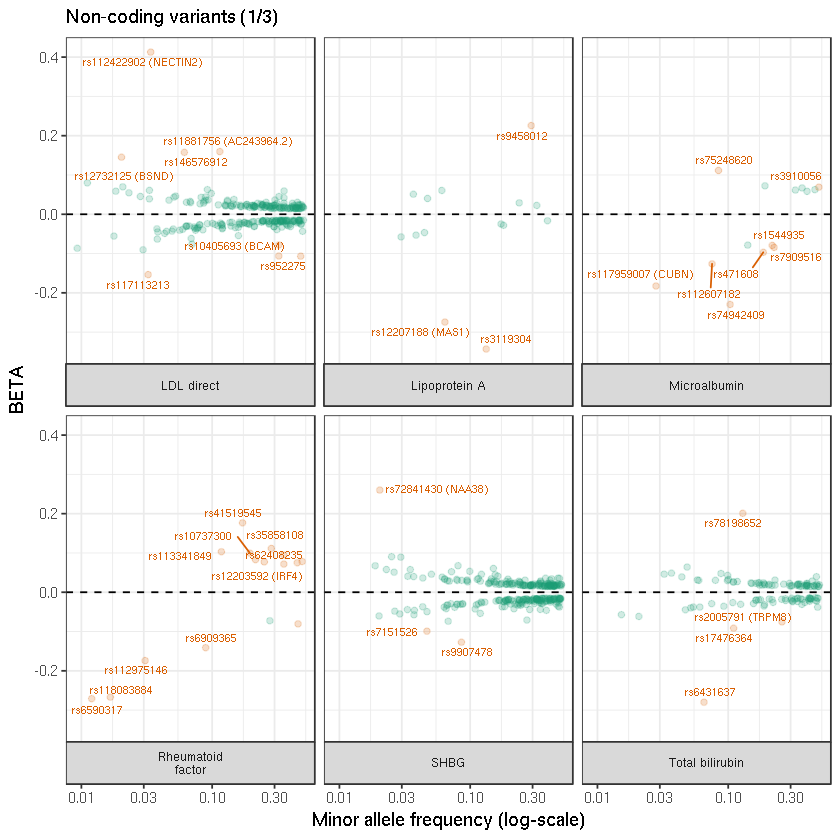

In [238]:
df_non_coding %>% 
filter(
    trait %in% df_non_coding_selected_traits
) %>% 
ggplot(
    aes(x=MAF, y=BETA, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point(alpha = .2) + 
theme_bw() + 
theme(
    strip.text = element_text(size=7),
    legend.position="none"    
)+
labs(
    title = 'Non-coding variants (1/3)',
    x = 'Minor allele frequency (log-scale)'
#     y = 'Beta or log odds ratio'
) +
scale_color_brewer(palette="Dark2") + 
scale_x_continuous(trans="log10") + 
facet_wrap(~trait, ncol = 3, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=2, force=2)

In [240]:
ggsave('cascade_non_coding1.png', width=7, height=9)
ggsave('cascade_non_coding1.pdf', width=7, height=9)


In [241]:
traits_non_coding_first_half <- df_non_coding %>% group_by(trait) %>% 
summarise(
    abs_max_BETA = max(abs(as.numeric(BETA)))
) %>% 
arrange(-abs_max_BETA) %>%
filter(! trait %in% df_non_coding_selected_traits) %>%
top_n(16)%>% select(trait) %>% pull()

Selecting by abs_max_BETA


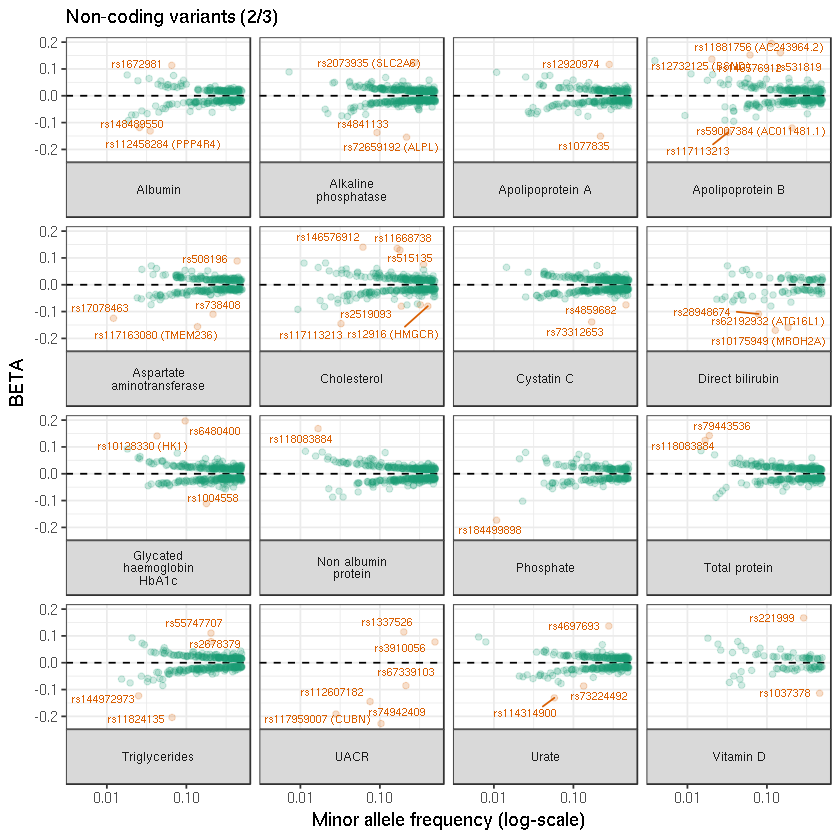

In [247]:
df_non_coding %>% 
filter(
    trait %in% traits_non_coding_first_half,
    ! trait %in% df_non_coding_selected_traits
) %>% 
ggplot(
    aes(x=MAF, y=BETA, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point(alpha = .2) + 
theme_bw() + 
theme(
    strip.text = element_text(size=7),
    legend.position="none"    
) +
labs(
    title = 'Non-coding variants (2/3)',
    x = 'Minor allele frequency (log-scale)'
) +
scale_color_brewer(palette="Dark2") + 
scale_x_continuous(trans="log10", breaks=10**(-4:-1)) + 
facet_wrap(~trait, ncol = 4, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=2, force=2)

In [248]:
ggsave('cascade_non_coding2.png', width=7, height=9)
ggsave('cascade_non_coding2.pdf', width=7, height=9)


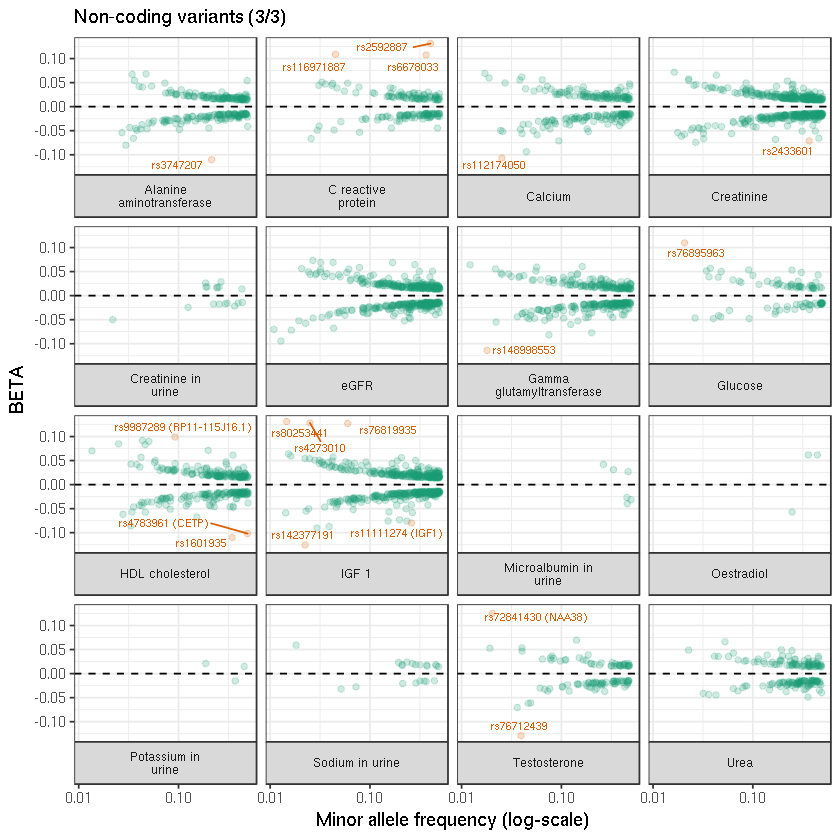

In [249]:
df_non_coding %>% 
filter(
    ! trait %in% traits_non_coding_first_half,
    ! trait %in% df_non_coding_selected_traits
) %>% 
ggplot(
    aes(x=MAF, y=BETA, color=outlier, label = ggrepel)
) +
geom_hline(yintercept = 0, linetype="dashed") +
geom_point(alpha = .2) + 
theme_bw() + 
theme(
    strip.text = element_text(size=7),
    legend.position="none"    
) +
labs(
    title = 'Non-coding variants (3/3)',
    x = 'Minor allele frequency (log-scale)'
) +
scale_color_brewer(palette="Dark2") + 
scale_x_continuous(trans="log10", breaks=10**(-4:-1)) + 
facet_wrap(~trait, ncol = 4, strip.position = "bottom", labeller = label_wrap_gen(17)) + 
ggrepel::geom_text_repel(size=2, force=2)

In [250]:
ggsave('cascade_non_coding3.png', width=7, height=9)
ggsave('cascade_non_coding3.pdf', width=7, height=9)


In [219]:
df %>% head()

trait,variant,CHROM,POS,ID,A1,BETA,SE,P,MAF,Csq,Consequence,HGVSp,Gene_symbol,Gene,is_outside_of_MHC,ld_indep
Alanine_aminotransferase,1:918270:C:T,1,918270,rs6659460,T,-0.0166554,0.00343255,1.22163e-06,0.15897150,non-coding,upstream_gene_variant,,PERM1,ENSG00000187642,TRUE,FALSE
Alanine_aminotransferase,1:2091762:C:T,1,2091762,rs75515273,T,0.0345253,0.00868704,7.05900e-05,0.02106885,non-coding,intron_variant,,PRKCZ,ENSG00000067606,TRUE,TRUE
Alanine_aminotransferase,1:2139916:C:T,1,2139916,rs115111747,T,0.0346381,0.00856507,5.25356e-05,0.02168240,non-coding,intron_variant,,FAAP20,ENSG00000162585,TRUE,FALSE
Alanine_aminotransferase,1:2165918:G:C,1,2165918,rs12061341,C,0.0312296,0.00468214,2.56343e-11,0.07729211,non-coding,intron_variant,,SKI,ENSG00000157933,TRUE,FALSE
Alanine_aminotransferase,1:2169079:C:T,1,2169079,rs10910032,T,0.0193333,0.00384670,5.01192e-07,0.11963136,non-coding,intron_variant,,SKI,ENSG00000157933,TRUE,FALSE
Alanine_aminotransferase,1:2173504:T:C,1,2173504,rs263526,C,-0.0104037,0.00257156,5.21806e-05,0.38452375,non-coding,intron_variant,,SKI,ENSG00000157933,TRUE,TRUE


In [90]:
df %>% fwrite(
    'sumstats.array.p1e4.tsv', sep='\t', row.names=FALSE
)

In [24]:
df %>% head()

trait,variant,CHROM,POS,ID,A1,BETA,SE,P,MAF,Csq,Consequence,HGVSp,Gene_symbol,Gene,is_outside_of_MHC,ld_indep
Alanine_aminotransferase,1:918270:C:T,1,918270,rs6659460,T,-0.0166554,0.00343255,1.22163e-06,0.15897150,non-coding,upstream_gene_variant,,PERM1,ENSG00000187642,TRUE,FALSE
Alanine_aminotransferase,1:2091762:C:T,1,2091762,rs75515273,T,0.0345253,0.00868704,7.05900e-05,0.02106885,non-coding,intron_variant,,PRKCZ,ENSG00000067606,TRUE,TRUE
Alanine_aminotransferase,1:2139916:C:T,1,2139916,rs115111747,T,0.0346381,0.00856507,5.25356e-05,0.02168240,non-coding,intron_variant,,FAAP20,ENSG00000162585,TRUE,FALSE
Alanine_aminotransferase,1:2165918:G:C,1,2165918,rs12061341,C,0.0312296,0.00468214,2.56343e-11,0.07729211,non-coding,intron_variant,,SKI,ENSG00000157933,TRUE,FALSE
Alanine_aminotransferase,1:2169079:C:T,1,2169079,rs10910032,T,0.0193333,0.00384670,5.01192e-07,0.11963136,non-coding,intron_variant,,SKI,ENSG00000157933,TRUE,FALSE
Alanine_aminotransferase,1:2173504:T:C,1,2173504,rs263526,C,-0.0104037,0.00257156,5.21806e-05,0.38452375,non-coding,intron_variant,,SKI,ENSG00000157933,TRUE,TRUE


In [22]:
getwd()

[1] "@@@@@@/projects/biomarkers/results/cascade"

In [29]:
df %>% filter(Csq != 'non-coding', abs(BETA) > .1, as.numeric(P) < 1e-7, is_outside_of_MHC) %>% 
select(variant, Csq) %>% unique() %>% count(Csq)

Csq,n
protein-altering,421
protein-truncating,53


In [30]:
df %>% filter(Csq != 'non-coding', abs(BETA) > .1, as.numeric(P) < 1e-7, is_outside_of_MHC) %>% 
filter(MAF < 0.05) %>%
select(variant, Csq) %>% unique() %>% count(Csq)

Csq,n
protein-altering,328
protein-truncating,51


In [31]:
df %>% filter(Csq != 'non-coding', abs(BETA) > .1, as.numeric(P) < 1e-7, is_outside_of_MHC) %>% 
filter(MAF < 0.01) %>%
select(variant, Csq) %>% unique() %>% count(Csq)

Csq,n
protein-altering,234
protein-truncating,46


In [32]:
df %>% filter(Csq != 'non-coding', abs(BETA) > .1, as.numeric(P) < 1e-7, is_outside_of_MHC) %>% 
filter(MAF < 0.001) %>%
select(variant, Csq) %>% unique() %>% count(Csq)

Csq,n
protein-altering,67
protein-truncating,28


In [ ]:
df %>% left_join(p_thr_df, by='Csq') %>%
mutate(is_significant = as.numeric(P) < as.numeric(significant_thr)) %>%
filter(is_significant, is_outside_of_MHC) %>% 

select(ID) %>% unique() %>% dim()

In [15]:
df %>% 
filter(
    as.numeric(P) < 1e-3,
    Csq == 'protein-altering',
) %>%
select(-CHROM, -POS) %>% 
mutate(outlier = if_else(abs(BETA) >= .1, TRUE, FALSE),) %>% 
fwrite(file.path(outd, 'sumstats.protein_altering.1e-3.tsv'), sep='\t', row.names=FALSE)


In [16]:
df %>% 
filter(
    as.numeric(P) < 1e-3,
    Csq == 'protein-truncating',
) %>%
select(-CHROM, -POS) %>% 
mutate(outlier = if_else(abs(BETA) >= .1, TRUE, FALSE),) %>% 
fwrite(file.path(outd, 'sumstats.protein_truncating.1e-3.tsv'), sep='\t', row.names=FALSE)
